In [1]:
import numpy as np, pandas as pd, pystan as ps, numpy.random as npr, matplotlib.pyplot as plt, h5py
%matplotlib inline 
from time import time
from pylab import plot, show, legend
from scipy.stats import pearsonr, spearmanr, norm, invgamma

#### Compile Stan model:

In [2]:
sm_gdP = ps.StanModel(file="gdP_logistic.stan") 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf1f70352a45ebcc131d582eff912e1a NOW.


#### Load data from file:

In [3]:
data = h5py.File("GZZ_data2.jld", "r")
X = data["X"].value
y = data["y"].value
ξ_true = data["xi_true"].value
d, Nobs = np.shape(X.transpose())

data = dict(N=Nobs, d=d, y=y.astype(int), X=X)

#### Run HMC with Stan:

In [4]:
control = dict(stepsize=1e-2, int_time=1e0, adapt_engaged=False) 

In [5]:
start = time()
fit_gdP = sm_gdP.sampling(data=data, 
                          thin=1, 
                          control=control, 
                          n_jobs=4, 
                          init="random", 
                          iter=2500, 
                          algorithm="HMC", 
                          warmup=0)
print(round((time()-start)/60, 2), "mins to run")
print(fit_gdP);

0.42 mins to run
Inference for Stan model: anon_model_bf1f70352a45ebcc131d582eff912e1a.
4 chains, each with iter=2500; warmup=0; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
xi[1]       -1.76    0.05   0.42  -2.72  -2.02  -1.71  -1.46  -1.05     71   1.05
xi[2]       -0.09    0.02   0.64   -1.7  -0.26  -0.02   0.13   1.17   1262    1.0
xi[3]       -0.19    0.02   0.68  -2.11  -0.35  -0.05    0.1   0.88   1137    1.0
xi[4]        0.05  6.5e-3   0.35  -0.62  -0.12   0.01   0.18   0.87   2885    1.0
xi[5]        0.09  9.2e-3   0.39  -0.59  -0.08   0.03   0.21   1.07   1821   1.01
xi[6]       -0.57    0.07   0.94  -3.12  -0.88  -0.22 6.9e-3   0.49    196   1.02
xi[7]        0.46    0.04   0.71   -0.4 3.4e-3   0.23   0.75   2.38    283   1.02
xi[8]       -0.19    0.02   0.53  -1.63  -0.33  -0.06   0.06   0.62    745    1.0
xi[9]        -0.1  9.5e-3   0.38  -1.05  -0.25  -0.04   0.

### ESS:

In [6]:
a = fit_gdP.summary()["summary"]
ess = a[:,-2]
print("Mean effective sample size:", np.round(np.mean(ess),1))

Mean effective sample size: 963.3


### Coverage:

In [7]:
trace = fit_gdP.extract()
xi_samples = trace["xi"]

In [8]:
np.shape(xi_samples)

(10000, 100)

In [9]:
cover = np.zeros(d)
ci = np.zeros((d,2))
for i in range(d) :
    ci[i,:] = np.percentile(xi_samples[:,i], q=[2.5, 97.5])
    cover[i] = (ci[i,0]<ξ_true[i])&(ξ_true[i]<ci[i,1])

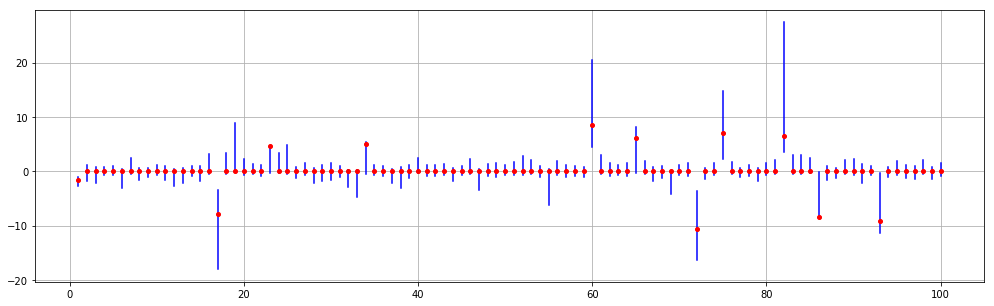

In [10]:
fig= plt.figure(figsize=(17,5))
for i in range(d) :
    plt.plot([i+1,i+1], ci[i], color="blue", lw=1.5)
plt.plot(np.arange(1,d+1), ξ_true, "ro", markersize=4)
plt.grid(True)

In [11]:
100*np.mean(cover)

97.0